# Gulf Guinea Toy
**Mapping CDR signals within Gulf Guinea Toy**: This notebook maps the fraction of CO2 uptake occuring within a finite regional domain using the global atlas estimates of uptake.

## Import Libraries

Load the Python packages for data handling, ROMS-Tools grids, atlas utilities, and helper functions.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr

import roms_tools as rt

import atlas_engine

/global/homes/m/mattlong/.conda/envs/cson-atlas/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configure Inputs and Define the Regional Grid

In [2]:
domain_name = "test-dummy"
grid_yaml = "../tests/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = 2
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "scheduler_file": None,
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
}

In [3]:
# Parameters
domain_name = "Gulf Guinea Toy"
grid_yaml = "/global/u2/m/mattlong/codes/atlas-calcs/blueprints/cson_roms-marbl_v0.1_gulf-guinea-toy/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = None
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
    "scheduler_file": "/pscratch/sd/m/mattlong/dask/dask_scheduler_file.zfw_w4vl.json",
}


## Configure Inputs and Define the Regional Grid

Set the domain name, grid YAML, injection settings, and optional `n_test` parameter, then load the ROMS-Tools grid. The grid defines the spatial boundaries of the regional domain and is plotted for a quick visual check.

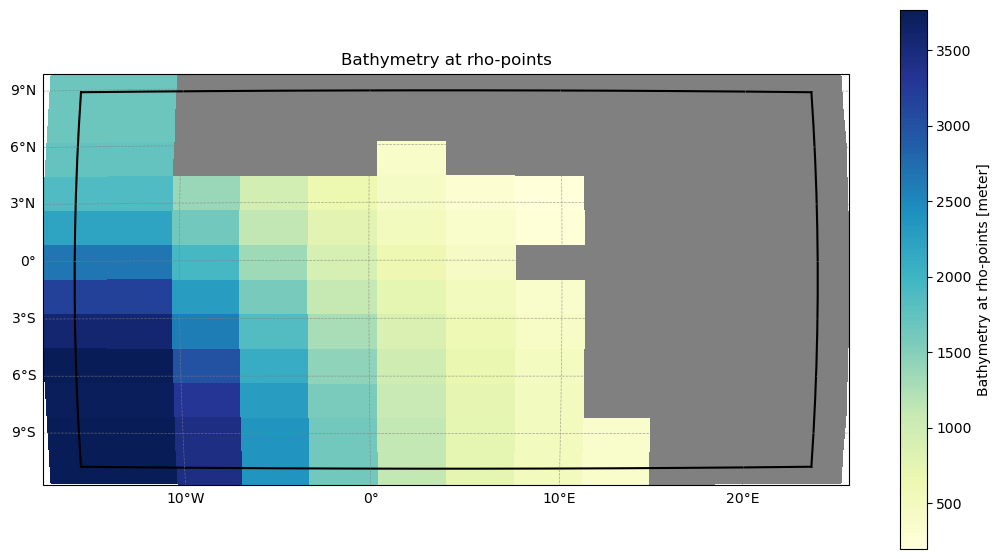

In [4]:
model_grid = atlas_engine.parsers.load_roms_tools_object(grid_yaml)
model_grid.plot()

## Create Analyzer and Identify Overlapping Polygons

Select the atlas dataset spec from `cdr_atlas.DATASET_REGISTRY` and initialize `AtlasModelGridAnalyzer`. The analyzer:

1. **Computes a convex hull** of the regional grid using `model_grid.ds.lat_u`/`lon_u`
2. **Performs point‑in‑polygon tests** against the atlas grid
3. **Extracts unique polygon IDs** that overlap the regional domain
4. **Builds a polygon mask** for within‑domain points

This convex‑hull approach captures non‑rectangular domains more accurately than a bounding box. 

Found 19 unique polygon IDs within model grid boundaries
Polygon IDs: [  5.  15.  20.  21.  64.  70.  73.  85. 103. 110. 113. 122. 129. 145.
 358. 487. 575. 600. 632.]


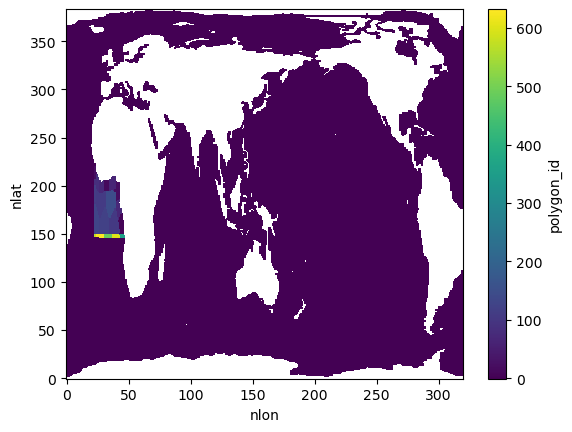

In [5]:
atlas_data = atlas_engine.datasets["oae-efficiency-map_atlas-v0"]

# Create AtlasModelGridAnalyzer instance
analyzer = atlas_data.analyzer(model_grid)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())

## Start Dask Cluster and Test a Single Polygon

A Dask cluster is created (if available) for distributed operations. Then we compute cumulative CO2 uptake for a single polygon using `n_test=3`, which limits the analysis to the first three files in the atlas sequence.

The integration:

1. **Ensures cached files** via the dataset spec
2. **Calculates the additional CO2 flux** (`FG_CO2 - FG_ALT_CO2`)
3. **Integrates over space and time** using:
   - Area weighting with `TAREA`
   - Time weighting with days per month
   - Spatial masking to the regional domain
4. **Computes cumulative integrals** over elapsed time

The outputs include total uptake, uptake within the regional grid, and the fraction captured.

In [6]:
cluster = atlas_engine.dask_cluster(**dask_cluster_kwargs)
cluster

Dashboard:
 https://jupyter.nersc.gov/user/mattlong/perlmutter-login-node-base/proxy/10.249.14.169:8787/status


/global/homes/m/mattlong/.conda/envs/cson-atlas/lib/python3.13/site-packages/distributed/client.py:1596: VersionMismatchWarning: Mismatched versions found

+-------------+----------+-----------+-----------+
| Package     | Client   | Scheduler | Workers   |
+-------------+----------+-----------+-----------+
| dask        | 2026.1.1 | 2025.12.0 | 2025.12.0 |
| distributed | 2026.1.1 | 2025.12.0 | 2025.12.0 |
+-------------+----------+-----------+-----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [7]:
%%time
# Integrate FG_CO2 for polygon 000 using the first 3 files in the sequence
results = analyzer.integrate_fg_co2_polygon_by_id(
    polygon_id=analyzer.polygon_ids_in_bounds[-1],
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=3,
)

print("FG_CO2 Integration Results:")
print(f"  Total integrated FG_CO2: {results['total'].values[-1]:.2e}")
print(f"  Within model grid: {results['within_grid'].values[-1]:.2e}")
print(f"  Fraction within grid: {results['fraction'].values[-1]:.2%}")

FG_CO2 Integration Results:
  Total integrated FG_CO2: 7.85e+10
  Within model grid: 6.63e+09
  Fraction within grid: 8.44%
CPU times: user 2.71 s, sys: 372 ms, total: 3.08 s
Wall time: 3.82 s


## Integrate CO<sub>2</sub> Flux for All Overlapping Polygons

Compute cumulative CO2 uptake for every polygon that overlaps the regional domain. Results are concatenated along `polygon_id`, yielding a dataset with dimensions `(polygon_id, elapsed_time)`.

In [8]:
%%time
ds = analyzer.integrate_fg_co2_polygons_within_boundaries(
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=n_test,
)   
ds

CPU times: user 1min 52s, sys: 9.64 s, total: 2min 2s
Wall time: 3min 33s


<xarray.Dataset> Size: 85kB
Dimensions:                 (polygon_id: 19, elapsed_time: 180)
Coordinates: (12/35)
    time                    (elapsed_time) object 1kB 0347-02-01 00:00:00 ......
    days_in_norm_year       timedelta64[ns] 8B 365 days
    grav                    float64 8B 980.6
    omega                   float64 8B 7.292e-05
    radius                  float64 8B 6.371e+08
    cp_sw                   float64 8B 3.996e+07
    ...                      ...
    sflux_factor            float64 8B 0.1
    nsurface_t              float64 8B 8.61e+04
    nsurface_u              float64 8B 8.297e+04
  * polygon_id              (polygon_id) float64 152B 5.0 15.0 ... 600.0 632.0
    injection_date          object 8B 1999-01-01 00:00:00
  * elapsed_time            (elapsed_time) timedelta64[ns] 1kB 0 days ... 544...
Data variables:
    total                   (polygon_id, elapsed_time) float64 27kB 5.289e+09...
    within_grid             (polygon_id, elapsed_time) float64 27kB 5.212e+09...
    fraction                (polygon_id, elapsed_time) float64 27kB 0.9855 .....

## Visualize Fraction of Uptake within the Regional Domain

Map the fraction of CO2 uptake captured within the regional domain for each polygon. The map highlights where a larger share of uptake falls inside the regional grid, helping assess how well the regional domain captures atlas signals.

In [9]:
ds_out = analyzer.set_field_within_boundaries(ds.fraction.isel(elapsed_time=-1))
ds_out.to_zarr(
    atlas_engine.paths.scratch / f"{domain_name.replace(' ', '-')}_fraction_within_boundaries.zarr",
    mode="w",
    consolidated=True,
)


/global/homes/m/mattlong/.conda/envs/cson-atlas/lib/python3.13/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


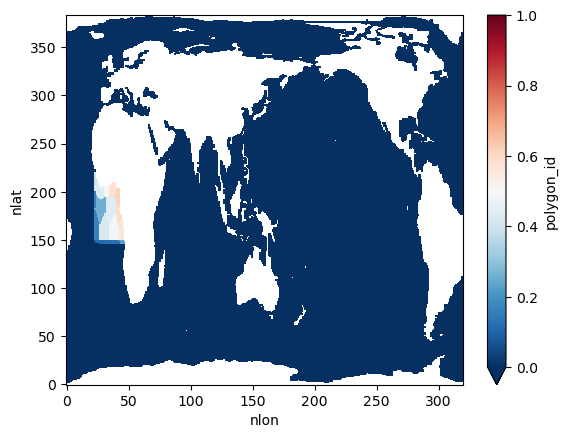

In [10]:
ds_out.plot(cmap="RdBu_r", vmin=0, vmax=1)

In [11]:
# check if LocalCluster is running and shutdown
if cluster.local_cluster:
    cluster.shutdown()